In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import argparse
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from tifffile import imshow
import open3d as o3d
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from features import Features
from fpfh_features import FPFHFeatures, get_fpfh_features
# from feature_extractors.rgb_fpfh_features import RGBFPFHFeatures
from mvtec3d import mvtec3d_classes, get_data_loader

In [3]:
classes = mvtec3d_classes()

methodS = [
    "FPFH"
    #"RGB + FPFH"
]

In [4]:
method = methodS[0]
cls = classes[0] # FPFH only

In [5]:
train_loader = get_data_loader("train", class_name=cls, img_size=224)

In [6]:
data = train_loader.dataset[0][0][1]

In [7]:
x = data[0].reshape(-1)[::10]
y = data[1].reshape(-1)[::10]
z = data[2].reshape(-1)[::10]

In [8]:
ind = ~((x==0) & (y==0) & (z==0))
x = x[ind]
y = y[ind]
z = z[ind]

In [9]:
px.scatter_3d(x=x, y=y, z=z)

### FPFH Extraction

In [226]:
test_loader = get_data_loader("test", cls, img_size=224)
data = test_loader.dataset[0][0][1]

In [227]:
fp_data = get_fpfh_features(data)

In [228]:
averager = torch.nn.AvgPool2d(3 ,stride=1)
resizer = torch.nn.AdaptiveAvgPool2d((28,28))
fp_data_averaged = averager(fp_data)
fp_data_avg_resized = resizer(fp_data_averaged)

In [229]:
output_data = fp_data_avg_resized.reshape(fp_data_avg_resized.shape[1],-1).T

In [230]:
output_data.shape

torch.Size([784, 33])

### Anomaly Map and Scoring

In [231]:
from padim.feature_extractor import FeatureExtractor
from padim.multi_variate_gaussian import MultiVariateGaussian
from padim.anomaly_map import AnomalyMapGenerator
from padim.tiler import Tiler

from padim.anomaly_map import *
from padim.torch_model import *

In [232]:
# gaussian = MultiVariateGaussian(224,224)
# mean, var = gaussian(fp_data)

In [233]:
from typing import Optional
def _cov(observations,
        rowvar: bool = False,
        bias: bool = False,
        ddof: Optional[int] = None,
        aweights = None,
        ):
        """Estimates covariance matrix like numpy.cov.

        Args:
            observations (Tensor): A 1-D or 2-D array containing multiple variables and observations.
                 Each row of `m` represents a variable, and each column a single
                 observation of all those variables. Also see `rowvar` below.
            rowvar (bool): If `rowvar` is True (default), then each row represents a
                variable, with observations in the columns. Otherwise, the relationship
                is transposed: each column represents a variable, while the rows
                contain observations. Defaults to False.
            bias (bool): Default normalization (False) is by ``(N - 1)``, where ``N`` is the
                number of observations given (unbiased estimate). If `bias` is True,
                then normalization is by ``N``. These values can be overridden by using
                the keyword ``ddof`` in numpy versions >= 1.5. Defaults to False
            ddof (Optional, int): If not ``None`` the default value implied by `bias` is overridden.
                Note that ``ddof=1`` will return the unbiased estimate, even if both
                `fweights` and `aweights` are specified, and ``ddof=0`` will return
                the simple average. See the notes for the details. The default value
                is ``None``.
            aweights (Tensor): 1-D array of observation vector weights. These relative weights are
                typically large for observations considered "important" and smaller for
                observations considered less "important". If ``ddof=0`` the array of
                weights can be used to assign probabilities to observation vectors. (Default value = None)


        Returns:
          The covariance matrix of the variables.
        """
        # ensure at least 2D
        if observations.dim() == 1:
            observations = observations.view(-1, 1)

        # treat each column as a data point, each row as a variable
        if rowvar and observations.shape[0] != 1:
            observations = observations.t()

        if ddof is None:
            if bias == 0:
                ddof = 1
            else:
                ddof = 0

        weights = aweights
        weights_sum: Any

        if weights is not None:
            if not torch.is_tensor(weights):
                weights = torch.tensor(weights, dtype=torch.float)  # pylint: disable=not-callable
            weights_sum = torch.sum(weights)
            avg = torch.sum(observations * (weights / weights_sum)[:, None], 0)
        else:
            avg = torch.mean(observations, 0)

        # Determine the normalization
        if weights is None:
            fact = observations.shape[0] - ddof
        elif ddof == 0:
            fact = weights_sum
        elif aweights is None:
            fact = weights_sum - ddof
        else:
            fact = weights_sum - ddof * torch.sum(weights * weights) / weights_sum

        observations_m = observations.sub(avg.expand_as(observations))

        if weights is None:
            x_transposed = observations_m.t()
        else:
            x_transposed = torch.mm(torch.diag(weights), observations_m).t()

        covariance = torch.mm(x_transposed, observations_m)
        
        covariance = covariance / 1
        
        return covariance.squeeze()

In [234]:
embedding = fp_data
batch, channel, height, width = embedding.size()
embedding_vectors = embedding.view(batch, channel, height * width)
mean = torch.mean(embedding_vectors, dim=0)
covariance = torch.zeros(size=(channel, channel, height * width))
identity = torch.eye(channel)
for i in range(height * width):
    covariance[:, :, i] = _cov(embedding_vectors[:, :, i], rowvar=False) + 0.01 * identity

# calculate inverse covariance as we need only the inverse
inv_covariance = torch.linalg.inv(covariance.permute(2, 0, 1))

In [235]:
inv_covariance

tensor([[[100.,   0.,   0.,  ...,   0.,   0.,  -0.],
         [  0., 100.,   0.,  ...,   0.,   0.,  -0.],
         [  0.,   0., 100.,  ...,   0.,   0.,  -0.],
         ...,
         [  0.,   0.,   0.,  ..., 100.,   0.,  -0.],
         [  0.,   0.,   0.,  ...,   0., 100.,  -0.],
         [  0.,   0.,   0.,  ...,   0.,   0., 100.]],

        [[100.,   0.,   0.,  ...,   0.,   0.,  -0.],
         [  0., 100.,   0.,  ...,   0.,   0.,  -0.],
         [  0.,   0., 100.,  ...,   0.,   0.,  -0.],
         ...,
         [  0.,   0.,   0.,  ..., 100.,   0.,  -0.],
         [  0.,   0.,   0.,  ...,   0., 100.,  -0.],
         [  0.,   0.,   0.,  ...,   0.,   0., 100.]],

        [[100.,   0.,   0.,  ...,   0.,   0.,  -0.],
         [  0., 100.,   0.,  ...,   0.,   0.,  -0.],
         [  0.,   0., 100.,  ...,   0.,   0.,  -0.],
         ...,
         [  0.,   0.,   0.,  ..., 100.,   0.,  -0.],
         [  0.,   0.,   0.,  ...,   0., 100.,  -0.],
         [  0.,   0.,   0.,  ...,   0.,   0., 100.]],

In [236]:
anomaly_map = AnomalyMapGenerator(image_size = (224,224))
distance = anomaly_map.compute_distance(fp_data.float(), (mean.float(), inv_covariance.float()))

In [237]:
distance

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [238]:
for i in distance.squeeze():
    for j in i:
        if j != 0:
            print(j)

In [239]:
def up_sample(distance: Tensor, image_size=224) -> Tensor:
        """Up sample anomaly score to match the input image size.

        Args:
            distance (Tensor): Anomaly score computed via the mahalanobis distance.

        Returns:
            Resized distance matrix matching the input image size
        """

        score_map = F.interpolate(
            distance.unsqueeze(1),
            size=image_size,
            mode="bilinear",
            align_corners=False,
        )
        return score_map    

In [240]:
def smooth_anomaly_map(anomaly_map: Tensor, sigma=4) -> Tensor:
    """Apply gaussian smoothing to the anomaly map.

    Args:
        anomaly_map (Tensor): Anomaly score for the test image(s).

    Returns:
        Filtered anomaly scores
    """

    kernel_size = 2 * int(4.0 * sigma + 0.5) + 1
    sigma = torch.as_tensor(sigma).to(anomaly_map.device)
    anomaly_map = gaussian_blur2d(anomaly_map, (kernel_size, kernel_size), sigma=(sigma, sigma))

    return anomaly_map

In [241]:
score_map = smooth_anomaly_map(up_sample(distance=distance))

In [242]:
data = test_loader.dataset[101][0][1]

In [243]:
data.shape

torch.Size([3, 224, 224])

### Testing

In [118]:
test_loader = get_data_loader("test", cls, img_size=224)

In [89]:
test = test_loader.dataset[0][1]
test = test.squeeze()

WARNING - 2022-07-08 14:49:09,298 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


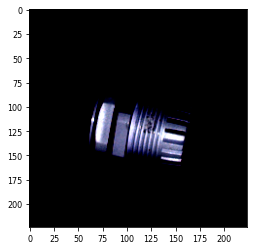

In [125]:
plt.imshow(test_loader.dataset[0][0][0].permute(2,1,0).numpy())

In [ ]:
px.scatter_3d(x=x, y=y, z=z)

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f63da4f7d90>)

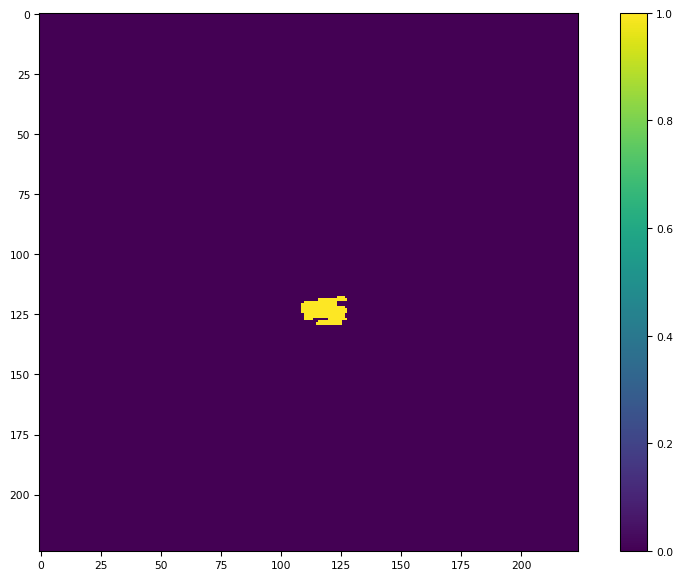

In [93]:
imshow(test.numpy())

In [26]:
image_rocaucs_df = pd.DataFrame(methodS, columns=['Method'])
pixel_rocaucs_df = pd.DataFrame(methodS, columns=['Method'])
au_pros_df = pd.DataFrame(methodS, columns=['Method'])

In [27]:
#Testing and Evaluation
image_rocaucs = dict()
pixel_rocaucs = dict()
au_pros = dict()
test_loader = get_data_loader("test", class_name=cls, img_size=224)
with torch.no_grad():
    for sample, mask, label in tqdm(test_loader, desc=f"Extracting test features for class {cls}"):
        method.predict(sample, mask, label)
method.calculate_metrics()
image_rocaucs["FPFH"] = round(method.image_rocauc, 3)
pixel_rocaucs["FPFH"] = round(method.pixel_rocauc, 3)
au_pros["FPFH"] = round(method.au_pro, 3)
print(f'Class: {cls}, FPFH Image ROCAUC: {method.image_rocauc:.3f}, FPFH Pixel ROCAUC: {method.pixel_rocauc:.3f}, FPFH AU-PRO: {method.au_pro:.3f}')

Extracting test features for class cable_gland: 100%|██████████| 108/108 [00:13<00:00,  8.03it/s]


Class: cable_gland, FPFH Image ROCAUC: 0.516, FPFH Pixel ROCAUC: 0.923, FPFH AU-PRO: 0.749


In [28]:
image_rocaucs_df['Mean'] = round(image_rocaucs_df.iloc[:, 1:].mean(axis=1),3)
pixel_rocaucs_df['Mean'] = round(pixel_rocaucs_df.iloc[:, 1:].mean(axis=1),3)
au_pros_df['Mean'] = round(au_pros_df.iloc[:, 1:].mean(axis=1),3)